In [93]:
import pandas as pd
import numpy as np
import random as rnd
import os
import datetime
import pickle

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm_notebook

from itertools import product

import gc

import lightgbm as lgb
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

pd.set_option('display.max_rows', 600)
pd.set_option('display.max_columns', 200)

import warnings
warnings.filterwarnings('ignore')

In [94]:
def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df

In [95]:
train = pd.read_csv('./input/train.csv')
test = pd.read_csv('./input/test.csv')

In [96]:
train.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
1         Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
2         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
3         Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
4         Lvl    AllPub       FR2       Gtl      NoRidge       Norm   

  Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
0       Norm     1Fam     2Story            7            5       2003   
1       Norm     1Fam     1Story            6            8       1976   
2       Norm     1Fam     2Story            7            5       2001   
3       Norm     1Fam     2Story            7            5       1915   
4       Norm     1Fam     2Story            8            5       2000   

   YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
0          2003     Gable  CompShg     VinylSd     VinylSd    BrkFace   
1          1976     Gable  CompShg     MetalSd     MetalSd       None   
2          2002     Gable  CompShg     VinylSd     VinylSd    BrkFace   
3          1970     Gable  CompShg     Wd Sdng     Wd Shng       None   
4          2000     Gable  CompShg     VinylSd     VinylSd    BrkFace   

   MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
0       196.0        Gd        TA      PConc       Gd       TA           No   
1         0.0        TA        TA     CBlock       Gd       TA           Gd   
2       162.0        Gd        TA      PConc       Gd       TA           Mn   
3         0.0        TA        TA     BrkTil       TA       Gd           No   
4       350.0        Gd        TA      PConc       Gd       TA           Av   

  BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
0          GLQ         706          Unf           0        150          856   
1          ALQ         978          Unf           0        284         1262   
2          GLQ         486          Unf           0        434          920   
3          ALQ         216          Unf           0        540          756   
4          GLQ         655          Unf           0        490         1145   

  Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  \
0    GasA        Ex          Y      SBrkr       856       854             0   
1    GasA        Ex          Y      SBrkr      1262         0             0   
2    GasA        Ex          Y      SBrkr       920       866             0   
3    GasA        Gd          Y      SBrkr       961       756             0   
4    GasA        Ex          Y      SBrkr      1145      1053             0   

   GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
0       1710             1             0         2         1             3   
1       1262             0             1         2         0             3   
2       1786             1             0         2         1             3   
3       1717             1             0         1         0             3   
4       2198             1             0         2         1             4   

   KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces FireplaceQu  \
0             1          Gd             8        Typ           0         NaN   
1             1          TA             6        Typ           1          TA   
2             1          Gd             6        Typ           1          TA   
3             1          Gd            

In [97]:
train.shape

(1460, 81)

In [98]:
test.shape

(1459, 80)

In [99]:
train.describe()

Id   MSSubClass  LotFrontage        LotArea  OverallQual  \
count  1460.000000  1460.000000  1201.000000    1460.000000  1460.000000   
mean    730.500000    56.897260    70.049958   10516.828082     6.099315   
std     421.610009    42.300571    24.284752    9981.264932     1.382997   
min       1.000000    20.000000    21.000000    1300.000000     1.000000   
25%     365.750000    20.000000    59.000000    7553.500000     5.000000   
50%     730.500000    50.000000    69.000000    9478.500000     6.000000   
75%    1095.250000    70.000000    80.000000   11601.500000     7.000000   
max    1460.000000   190.000000   313.000000  215245.000000    10.000000   

       OverallCond    YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1  \
count  1460.000000  1460.000000   1460.000000  1452.000000  1460.000000   
mean      5.575342  1971.267808   1984.865753   103.685262   443.639726   
std       1.112799    30.202904     20.645407   181.066207   456.098091   
min       1.000000  1872.000000   1950.000000     0.000000     0.000000   
25%       5.000000  1954.000000   1967.000000     0.000000     0.000000   
50%       5.000000  1973.000000   1994.000000     0.000000   383.500000   
75%       6.000000  2000.000000   2004.000000   166.000000   712.250000   
max       9.000000  2010.000000   2010.000000  1600.000000  5644.000000   

        BsmtFinSF2    BsmtUnfSF  TotalBsmtSF     1stFlrSF     2ndFlrSF  \
count  1460.000000  1460.000000  1460.000000  1460.000000  1460.000000   
mean     46.549315   567.240411  1057.429452  1162.626712   346.992466   
std     161.319273   441.866955   438.705324   386.587738   436.528436   
min       0.000000     0.000000     0.000000   334.000000     0.000000   
25%       0.000000   223.000000   795.750000   882.000000     0.000000   
50%       0.000000   477.500000   991.500000  1087.000000     0.000000   
75%       0.000000   808.000000  1298.250000  1391.250000   728.000000   
max    1474.000000  2336.000000  6110.000000  4692.000000  2065.000000   

       LowQualFinSF    GrLivArea  BsmtFullBath  BsmtHalfBath     FullBath  \
count   1460.000000  1460.000000   1460.000000   1460.000000  1460.000000   
mean       5.844521  1515.463699      0.425342      0.057534     1.565068   
std       48.623081   525.480383      0.518911      0.238753     0.550916   
min        0.000000   334.000000      0.000000      0.000000     0.000000   
25%        0.000000  1129.500000      0.000000      0.000000     1.000000   
50%        0.000000  1464.000000      0.000000      0.000000     2.000000   
75%        0.000000  1776.750000      1.000000      0.000000     2.000000   
max      572.000000  5642.000000      3.000000      2.000000     3.000000   

          HalfBath  BedroomAbvGr  KitchenAbvGr  TotRmsAbvGrd   Fireplaces  \
count  1460.000000   1460.000000   1460.000000   1460.000000  1460.000000   
mean      0.382877      2.866438      1.046575      6.517808     0.613014   
std       0.502885      0.815778      0.220338      1.625393     0.644666   
min       0.000000      0.000000      0.000000      2.000000     0.000000   
25%       0.000000      2.000000      1.000000      5.000000     0.000000   
50%       0.000000      3.000000      1.000000      6.000000     1.000000   
75%       1.000000      3.000000      1.000000      7.000000     1.000000   
max       2.000000      8.000000      3.000000     14.000000     3.000000   

       GarageYrBlt   GarageCars   GarageArea   WoodDeckSF  OpenPorchSF  \
count  1379.000000  1460.000000  1460.000000  1460.000000  1460.000000   
mean   1978.506164     1.767123   472.980137    94.244521    46.660274   
std      24.689725     0.747315   213.804841   125.338794    66.256028   
min    1900.000000     0.000000     0.000000     0.000000     0.000000   
25%    1961.000000     1.000000   334.500000     0.000000     0.000000   
50%    1980.000000     2.000000   480.000000     0.000000    25.000000   
75%    2002.000000     2.000000   576.000000   168.000000    68.000000   
max    2

In [100]:
train.describe(include=['O'])

MSZoning Street Alley LotShape LandContour Utilities LotConfig  \
count      1460   1460    91     1460        1460      1460      1460   
unique        5      2     2        4           4         2         5   
top          RL   Pave  Grvl      Reg         Lvl    AllPub    Inside   
freq       1151   1454    50      925        1311      1459      1052   

       LandSlope Neighborhood Condition1 Condition2 BldgType HouseStyle  \
count       1460         1460       1460       1460     1460       1460   
unique         3           25          9          8        5          8   
top          Gtl        NAmes       Norm       Norm     1Fam     1Story   
freq        1382          225       1260       1445     1220        726   

       RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType ExterQual  \
count       1460     1460        1460        1460       1452      1460   
unique         6        8          15          16          4         4   
top        Gable  CompShg     VinylSd     VinylSd       None        TA   
freq        1141     1434         515         504        864       906   

       ExterCond Foundation BsmtQual BsmtCond BsmtExposure BsmtFinType1  \
count       1460       1460     1423     1423         1422         1423   
unique         5          6        4        4            4            6   
top           TA      PConc       TA       TA           No          Unf   
freq        1282        647      649     1311          953          430   

       BsmtFinType2 Heating HeatingQC CentralAir Electrical KitchenQual  \
count          1422    1460      1460       1460       1459        1460   
unique            6       6         5          2          5           4   
top             Unf    GasA        Ex          Y      SBrkr          TA   
freq           1256    1428       741       1365       1334         735   

       Functional FireplaceQu GarageType GarageFinish GarageQual GarageCond  \
count        1460         770       1379         1379       1379       1379   
unique          7           5          6            3          5          5   
top           Typ          Gd     Attchd          Unf         TA         TA   
freq         1360         380        870          605       1311       1326   

       PavedDrive PoolQC  Fence MiscFeature SaleType SaleCondition  
count        1460      7    281          54     1460          1460  
unique          3      3      4           4        9             6  
top             Y     Gd  MnPrv        Shed       WD        Normal  
freq         1340      3    157          49     1267          1198

In [101]:
from scipy import stats

In [102]:
train[train.columns[train.dtypes!=object]].skew()

Id                0.000000
MSSubClass        1.407657
LotFrontage       2.163569
LotArea          12.207688
OverallQual       0.216944
OverallCond       0.693067
YearBuilt        -0.613461
YearRemodAdd     -0.503562
MasVnrArea        2.669084
BsmtFinSF1        1.685503
BsmtFinSF2        4.255261
BsmtUnfSF         0.920268
TotalBsmtSF       1.524255
1stFlrSF          1.376757
2ndFlrSF          0.813030
LowQualFinSF      9.011341
GrLivArea         1.366560
BsmtFullBath      0.596067
BsmtHalfBath      4.103403
FullBath          0.036562
HalfBath          0.675897
BedroomAbvGr      0.211790
KitchenAbvGr      4.488397
TotRmsAbvGrd      0.676341
Fireplaces        0.649565
GarageYrBlt      -0.649415
GarageCars       -0.342549
GarageArea        0.179981
WoodDeckSF        1.541376
OpenPorchSF       2.364342
EnclosedPorch     3.089872
3SsnPorch        10.304342
ScreenPorch       4.122214
PoolArea         14.828374
MiscVal          24.476794
MoSold            0.212053
YrSold            0.096269
S

In [103]:
train[train.columns[train.dtypes!=object]].kurt()

Id                -1.200000
MSSubClass         1.580188
LotFrontage       17.452867
LotArea          203.243271
OverallQual        0.096293
OverallCond        1.106413
YearBuilt         -0.439552
YearRemodAdd      -1.272245
MasVnrArea        10.082417
BsmtFinSF1        11.118236
BsmtFinSF2        20.113338
BsmtUnfSF          0.474994
TotalBsmtSF       13.250483
1stFlrSF           5.745841
2ndFlrSF          -0.553464
LowQualFinSF      83.234817
GrLivArea          4.895121
BsmtFullBath      -0.839098
BsmtHalfBath      16.396642
FullBath          -0.857043
HalfBath          -1.076927
BedroomAbvGr       2.230875
KitchenAbvGr      21.532404
TotRmsAbvGrd       0.880762
Fireplaces        -0.217237
GarageYrBlt       -0.418341
GarageCars         0.220998
GarageArea         0.917067
WoodDeckSF         2.992951
OpenPorchSF        8.490336
EnclosedPorch     10.430766
3SsnPorch        123.662379
ScreenPorch       18.439068
PoolArea         223.268499
MiscVal          701.003342
MoSold            -0

In [104]:
train_skew = train[train.columns[train.dtypes!=object]].skew()

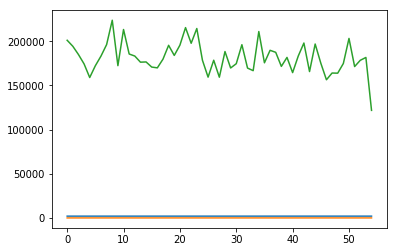

In [105]:
plt.plot(train.groupby(['YrSold', 'MoSold'], as_index=False)['SalePrice'].mean())

In [106]:
train[train['SalePrice']>700000]

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
691    692          60       RL        104.0    21535   Pave   NaN      IR1   
1182  1183          60       RL        160.0    15623   Pave   NaN      IR1   

     LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
691          Lvl    AllPub    Corner       Gtl      NoRidge       Norm   
1182         Lvl    AllPub    Corner       Gtl      NoRidge       Norm   

     Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
691        Norm     1Fam     2Story           10            6       1994   
1182       Norm     1Fam     2Story           10            5       1996   

      YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
691           1995     Gable  WdShngl     HdBoard     HdBoard    BrkFace   
1182          1996       Hip  CompShg     Wd Sdng     ImStucc       None   

      MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond  \
691       1170.0        Ex        TA      PConc       Ex       TA   
1182         0.0        Gd        TA      PConc       Ex       TA   

     BsmtExposure BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  \
691            Gd          GLQ        1455          Unf           0   
1182           Av          GLQ        2096          Unf           0   

      BsmtUnfSF  TotalBsmtSF Heating HeatingQC CentralAir Electrical  \
691         989         2444    GasA        Ex          Y      SBrkr   
1182        300         2396    GasA        Ex          Y      SBrkr   

      1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  \
691       2444      1872             0       4316             0             1   
1182      2411      2065             0       4476             1             0   

      FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr KitchenQual  \
691          3         1             4             1          Ex   
1182         3         1             4             1          Ex   

      TotRmsAbvGrd Functional  Fireplaces FireplaceQu GarageType  GarageYrBlt  \
691             10        Typ           2          Ex     Attchd       1994.0   
1182            10        Typ           2          TA     Attchd       1996.0   

     GarageFinish  GarageCars  GarageArea GarageQual GarageCond PavedDrive  \
691           Fin           3         832         TA         TA          Y   
1182          Fin           3         813         TA         TA          Y   

      WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  \
691          382           50              0          0            0   
1182         171           78              0          0            0   

      PoolArea PoolQC  Fence MiscFeature  MiscVal  MoSold  YrSold SaleType  \
691          0    NaN    NaN         NaN        0       1    2007       WD   
1182       555     Ex  MnPrv         NaN        0       7    2007       WD   

     SaleCondition  SalePrice  
691         Normal     755000  
1182       Abnorml     745000

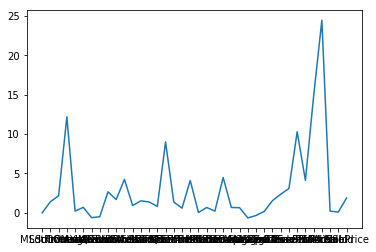

In [107]:
plt.plot(train_skew)

In [108]:
skewed_columns = train_skew.index[train_skew.abs()>1.5]

In [109]:
y_train = train['SalePrice'].values

In [110]:
train.drop(['SalePrice'], axis=1, inplace=True)

In [111]:
all_data = pd.concat([train, test], axis=0)

In [112]:
all_data.shape

(2919, 80)

In [113]:
all_data_skew = all_data[all_data.columns[train.dtypes!=object]].skew()
skewed_columns = all_data_skew.index[all_data_skew.abs()>1.5]

In [114]:
skewed_columns

Index(['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF2', 'LowQualFinSF',
       'BsmtHalfBath', 'KitchenAbvGr', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal'],
      dtype='object')

In [115]:
np.log(all_data[skewed_columns]).skew()

LotFrontage     -0.889314
LotArea         -0.505542
MasVnrArea            NaN
BsmtFinSF2            NaN
LowQualFinSF          NaN
BsmtHalfBath          NaN
KitchenAbvGr          NaN
WoodDeckSF            NaN
OpenPorchSF           NaN
EnclosedPorch         NaN
3SsnPorch             NaN
ScreenPorch           NaN
PoolArea              NaN
MiscVal               NaN
dtype: float64

In [116]:
stats.skew(np.log(y_train))

0.1212103673013655

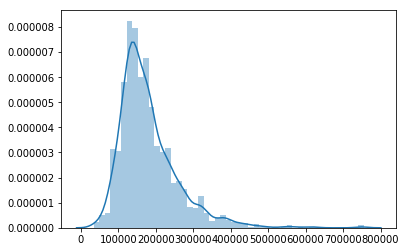

In [117]:
sns.distplot(y_train)

In [118]:
all_data.isnull().sum().sort_values(ascending=False)

PoolQC           2909
MiscFeature      2814
Alley            2721
Fence            2348
FireplaceQu      1420
LotFrontage       486
GarageCond        159
GarageQual        159
GarageYrBlt       159
GarageFinish      159
GarageType        157
BsmtCond           82
BsmtExposure       82
BsmtQual           81
BsmtFinType2       80
BsmtFinType1       79
MasVnrType         24
MasVnrArea         23
MSZoning            4
BsmtHalfBath        2
Utilities           2
Functional          2
BsmtFullBath        2
BsmtFinSF1          1
Exterior1st         1
Exterior2nd         1
BsmtFinSF2          1
BsmtUnfSF           1
TotalBsmtSF         1
SaleType            1
Electrical          1
KitchenQual         1
GarageArea          1
GarageCars          1
HouseStyle          0
LandSlope           0
MSSubClass          0
LotArea             0
Street              0
LotShape            0
LandContour         0
LotConfig           0
Neighborhood        0
OverallQual         0
Condition1          0
Condition2

In [119]:
total = all_data.isnull().sum().sort_values(ascending = False)
percent = (all_data.isnull().sum()/all_data.isnull().count()).sort_values(ascending = False)
missing_data = pd.concat([total, percent], axis = 1, keys = ['Total', 'Percent'])
missing_data.head(40)

Total   Percent
PoolQC         2909  0.996574
MiscFeature    2814  0.964029
Alley          2721  0.932169
Fence          2348  0.804385
FireplaceQu    1420  0.486468
LotFrontage     486  0.166495
GarageCond      159  0.054471
GarageQual      159  0.054471
GarageYrBlt     159  0.054471
GarageFinish    159  0.054471
GarageType      157  0.053786
BsmtCond         82  0.028092
BsmtExposure     82  0.028092
BsmtQual         81  0.027749
BsmtFinType2     80  0.027407
BsmtFinType1     79  0.027064
MasVnrType       24  0.008222
MasVnrArea       23  0.007879
MSZoning          4  0.001370
BsmtHalfBath      2  0.000685
Utilities         2  0.000685
Functional        2  0.000685
BsmtFullBath      2  0.000685
BsmtFinSF1        1  0.000343
Exterior1st       1  0.000343
Exterior2nd       1  0.000343
BsmtFinSF2        1  0.000343
BsmtUnfSF         1  0.000343
TotalBsmtSF       1  0.000343
SaleType          1  0.000343
Electrical        1  0.000343
KitchenQual       1  0.000343
GarageArea        1  0.000343
GarageCars        1  0.000343
HouseStyle        0  0.000000
LandSlope         0  0.000000
MSSubClass        0  0.000000
LotArea           0  0.000000
Street            0  0.000000
LotShape          0  0.000000

In [120]:
all_data.columns[all_data.dtypes==object]

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

In [121]:
all_data[all_data.columns[all_data.dtypes==object]].isnull().sum().sort_values(ascending=False)

PoolQC           2909
MiscFeature      2814
Alley            2721
Fence            2348
FireplaceQu      1420
GarageCond        159
GarageQual        159
GarageFinish      159
GarageType        157
BsmtCond           82
BsmtExposure       82
BsmtQual           81
BsmtFinType2       80
BsmtFinType1       79
MasVnrType         24
MSZoning            4
Functional          2
Utilities           2
Electrical          1
KitchenQual         1
SaleType            1
Exterior2nd         1
Exterior1st         1
Heating             0
Condition1          0
Street              0
PavedDrive          0
LotShape            0
LandContour         0
LotConfig           0
LandSlope           0
Neighborhood        0
RoofStyle           0
Condition2          0
BldgType            0
HouseStyle          0
HeatingQC           0
RoofMatl            0
ExterQual           0
ExterCond           0
Foundation          0
CentralAir          0
SaleCondition       0
dtype: int64

In [122]:
all_data['OverallQual+Cond'] =all_data['OverallQual'] + all_data['OverallCond']
all_data['OverallQual*Cond'] =all_data['OverallQual'] * all_data['OverallCond']

In [123]:
#for col in all_data.columns[all_data.dtypes==object]:
#    all_data[col] = all_data[col].factorize()[0]

In [124]:
total = all_data.isnull().sum().sort_values(ascending = False)
percent = (all_data.isnull().sum()/all_data.isnull().count()).sort_values(ascending = False)
missing_data = pd.concat([total, percent], axis = 1, keys = ['Total', 'Percent'])
missing_data.head(40)

Total   Percent
PoolQC             2909  0.996574
MiscFeature        2814  0.964029
Alley              2721  0.932169
Fence              2348  0.804385
FireplaceQu        1420  0.486468
LotFrontage         486  0.166495
GarageFinish        159  0.054471
GarageYrBlt         159  0.054471
GarageQual          159  0.054471
GarageCond          159  0.054471
GarageType          157  0.053786
BsmtCond             82  0.028092
BsmtExposure         82  0.028092
BsmtQual             81  0.027749
BsmtFinType2         80  0.027407
BsmtFinType1         79  0.027064
MasVnrType           24  0.008222
MasVnrArea           23  0.007879
MSZoning              4  0.001370
BsmtFullBath          2  0.000685
Utilities             2  0.000685
Functional            2  0.000685
BsmtHalfBath          2  0.000685
BsmtUnfSF             1  0.000343
GarageCars            1  0.000343
BsmtFinSF1            1  0.000343
SaleType              1  0.000343
BsmtFinSF2            1  0.000343
GarageArea            1  0.000343
KitchenQual           1  0.000343
TotalBsmtSF           1  0.000343
Exterior2nd           1  0.000343
Exterior1st           1  0.000343
Electrical            1  0.000343
YearRemodAdd          0  0.000000
RoofMatl              0  0.000000
RoofStyle             0  0.000000
OverallQual*Cond      0  0.000000
YearBuilt             0  0.000000
OverallCond           0  0.000000

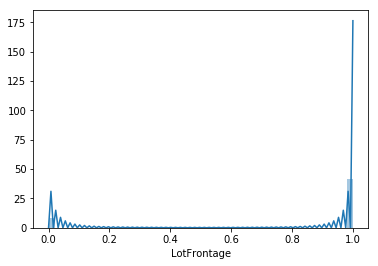

In [125]:
sns.distplot(all_data['LotFrontage'].notnull())

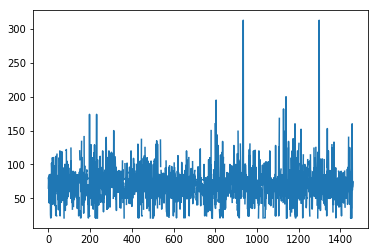

In [126]:
plt.plot(all_data['LotFrontage'])

In [127]:
all_data['LotFrontage'].mean()

69.30579531442663

In [128]:
all_data['LotArea']

0         8450
1         9600
2        11250
3         9550
4        14260
5        14115
6        10084
7        10382
8         6120
9         7420
10       11200
11       11924
12       12968
13       10652
14       10920
15        6120
16       11241
17       10791
18       13695
19        7560
20       14215
21        7449
22        9742
23        4224
24        8246
25       14230
26        7200
27       11478
28       16321
29        6324
30        8500
31        8544
32       11049
33       10552
34        7313
35       13418
36       10859
37        8532
38        7922
39        6040
40        8658
41       16905
42        9180
43        9200
44        7945
45        7658
46       12822
47       11096
48        4456
49        7742
50       13869
51        6240
52        8472
53       50271
54        7134
55       10175
56        2645
57       11645
58       13682
59        7200
60       13072
61        7200
62        6442
63       10300
64        9375
65        9591
66       1

In [129]:
all_data['LotFrontage'].notnull()

0        True
1        True
2        True
3        True
4        True
5        True
6        True
7       False
8        True
9        True
10       True
11       True
12      False
13       True
14      False
15       True
16      False
17       True
18       True
19       True
20       True
21       True
22       True
23       True
24      False
25       True
26       True
27       True
28       True
29       True
30       True
31      False
32       True
33       True
34       True
35       True
36       True
37       True
38       True
39       True
40       True
41       True
42      False
43      False
44       True
45       True
46       True
47       True
48       True
49       True
50      False
51       True
52       True
53       True
54       True
55       True
56       True
57       True
58       True
59       True
60       True
61       True
62       True
63       True
64      False
65       True
66      False
67       True
68       True
69       True
70       True
71    

In [130]:
all_data['GarageYrBlt'].fillna(0, inplace=True)

In [131]:
all_data['MasVnrArea']

0        196.0
1          0.0
2        162.0
3          0.0
4        350.0
5          0.0
6        186.0
7        240.0
8          0.0
9          0.0
10         0.0
11       286.0
12         0.0
13       306.0
14       212.0
15         0.0
16       180.0
17         0.0
18         0.0
19         0.0
20       380.0
21         0.0
22       281.0
23         0.0
24         0.0
25       640.0
26         0.0
27       200.0
28         0.0
29         0.0
30         0.0
31         0.0
32         0.0
33         0.0
34       246.0
35       132.0
36         0.0
37       650.0
38         0.0
39         0.0
40       101.0
41         0.0
42         0.0
43         0.0
44         0.0
45       412.0
46         0.0
47         0.0
48         0.0
49         0.0
50         0.0
51         0.0
52         0.0
53         0.0
54         0.0
55       272.0
56       456.0
57         0.0
58      1031.0
59         0.0
60         0.0
61         0.0
62       178.0
63         0.0
64       573.0
65       344.0
66       2

In [132]:
all_data[all_data['MasVnrType']!=1]['MasVnrArea'].median()

0.0

In [133]:
all_data['MasVnrArea'].fillna(all_data[all_data['MasVnrType']!=1]['MasVnrArea'].median(), inplace=True)

In [134]:
all_data['LotFrontage'].fillna(all_data['LotFrontage'].median(), inplace=True)

In [135]:
all_data.fillna(all_data.mean(), inplace=True)

In [136]:
all_data.skew()

Id                   0.000000
MSSubClass           1.376165
LotFrontage          1.675713
LotArea             12.829025
OverallQual          0.197212
OverallCond          0.570605
YearBuilt           -0.600114
YearRemodAdd        -0.451252
MasVnrArea           2.614936
BsmtFinSF1           1.425966
BsmtFinSF2           4.148166
BsmtUnfSF            0.919981
TotalBsmtSF          1.163082
1stFlrSF             1.470360
2ndFlrSF             0.862118
LowQualFinSF        12.094977
GrLivArea            1.270010
BsmtFullBath         0.624276
BsmtHalfBath         3.933365
FullBath             0.167692
HalfBath             0.694924
BedroomAbvGr         0.326492
KitchenAbvGr         4.304467
TotRmsAbvGrd         0.758757
Fireplaces           0.733872
GarageYrBlt         -3.908213
GarageCars          -0.218410
GarageArea           0.241342
WoodDeckSF           1.843380
OpenPorchSF          2.536417
EnclosedPorch        4.005950
3SsnPorch           11.381914
ScreenPorch          3.948723
PoolArea  

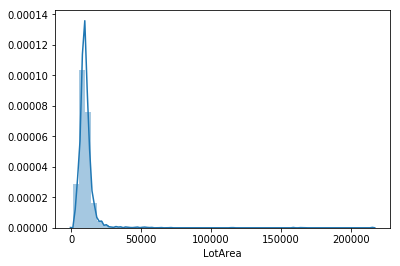

In [137]:
sns.distplot((all_data['LotArea']))

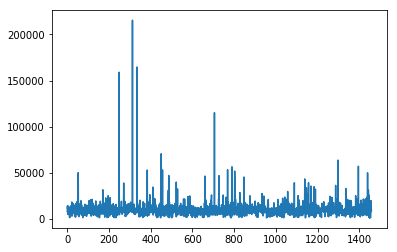

In [138]:
plt.plot((all_data['LotArea']))

In [139]:
all_data['LotArea'].mean()

10168.11408016444

In [140]:
np.percentile(all_data['LotArea'], 95)

17142.899999999998

In [141]:
all_data['LotArea'] = np.clip(all_data['LotArea'], a_min=all_data['LotArea'].min(), a_max=np.percentile(all_data['LotArea'], 95))

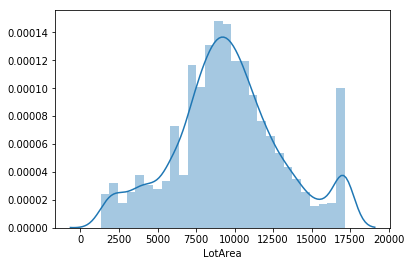

In [142]:
sns.distplot((all_data['LotArea']))

In [143]:
all_data.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0   8450.0   Pave   NaN      Reg   
1   2          20       RL         80.0   9600.0   Pave   NaN      Reg   
2   3          60       RL         68.0  11250.0   Pave   NaN      IR1   
3   4          70       RL         60.0   9550.0   Pave   NaN      IR1   
4   5          60       RL         84.0  14260.0   Pave   NaN      IR1   

  LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
1         Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
2         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
3         Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
4         Lvl    AllPub       FR2       Gtl      NoRidge       Norm   

  Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
0       Norm     1Fam     2Story            7            5       2003   
1       Norm     1Fam     1Story            6            8       1976   
2       Norm     1Fam     2Story            7            5       2001   
3       Norm     1Fam     2Story            7            5       1915   
4       Norm     1Fam     2Story            8            5       2000   

   YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
0          2003     Gable  CompShg     VinylSd     VinylSd    BrkFace   
1          1976     Gable  CompShg     MetalSd     MetalSd       None   
2          2002     Gable  CompShg     VinylSd     VinylSd    BrkFace   
3          1970     Gable  CompShg     Wd Sdng     Wd Shng       None   
4          2000     Gable  CompShg     VinylSd     VinylSd    BrkFace   

   MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
0       196.0        Gd        TA      PConc       Gd       TA           No   
1         0.0        TA        TA     CBlock       Gd       TA           Gd   
2       162.0        Gd        TA      PConc       Gd       TA           Mn   
3         0.0        TA        TA     BrkTil       TA       Gd           No   
4       350.0        Gd        TA      PConc       Gd       TA           Av   

  BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
0          GLQ       706.0          Unf         0.0      150.0        856.0   
1          ALQ       978.0          Unf         0.0      284.0       1262.0   
2          GLQ       486.0          Unf         0.0      434.0        920.0   
3          ALQ       216.0          Unf         0.0      540.0        756.0   
4          GLQ       655.0          Unf         0.0      490.0       1145.0   

  Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  \
0    GasA        Ex          Y      SBrkr       856       854             0   
1    GasA        Ex          Y      SBrkr      1262         0             0   
2    GasA        Ex          Y      SBrkr       920       866             0   
3    GasA        Gd          Y      SBrkr       961       756             0   
4    GasA        Ex          Y      SBrkr      1145      1053             0   

   GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
0       1710           1.0           0.0         2         1             3   
1       1262           0.0           1.0         2         0             3   
2       1786           1.0           0.0         2         1             3   
3       1717           1.0           0.0         1         0             3   
4       2198           1.0           0.0         2         1             4   

   KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces FireplaceQu  \
0             1          Gd             8        Typ           0         NaN   
1             1          TA             6        Typ           1          TA   
2             1          Gd             6        Typ           1          TA   
3             1          Gd            

In [144]:
train = all_data.iloc[:train.shape[0], :]
test = all_data.iloc[train.shape[0]:, :]

In [145]:
test_id = test['Id'].values

In [146]:
del train['Id'], test['Id']

In [147]:
y_train_log = np.log(y_train)

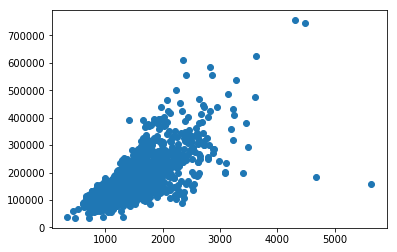

In [148]:
plt.scatter(x=train['GrLivArea'], y=y_train)

In [149]:
train[train['GrLivArea']>4000]['GrLivArea']

523     4676
691     4316
1182    4476
1298    5642
Name: GrLivArea, dtype: int64

In [150]:
train = pd.concat([train, pd.DataFrame({'SalePrice':y_train})], axis=1)

In [151]:
train.drop(train[train['GrLivArea']>4600].index, inplace=True)

In [152]:
train.shape

(1458, 82)

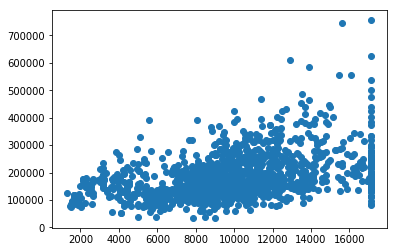

In [153]:
plt.scatter(x=train['LotArea'], y=train['SalePrice'])

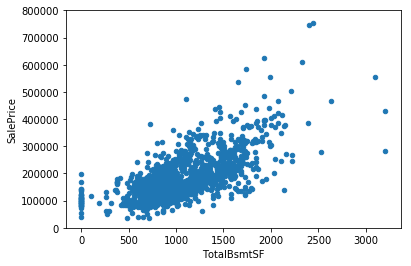

In [154]:
train.plot.scatter(x='TotalBsmtSF', y='SalePrice', ylim=(0,800000));

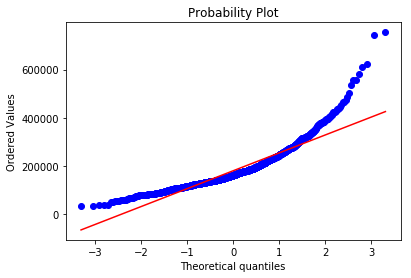

In [155]:
res = stats.probplot(train['SalePrice'], plot=plt)

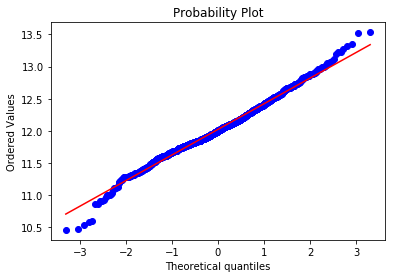

In [156]:
res = stats.probplot(np.log(train['SalePrice']), plot=plt)

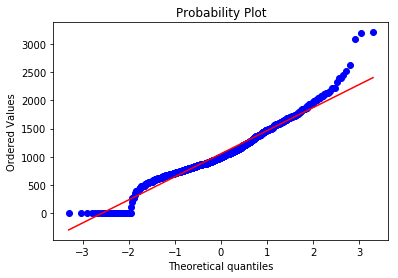

In [157]:
res = stats.probplot(train['TotalBsmtSF'], plot=plt)

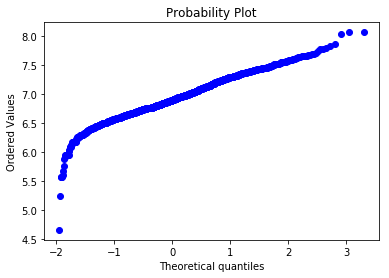

In [158]:
res = stats.probplot(np.log(train['TotalBsmtSF']), plot=plt)

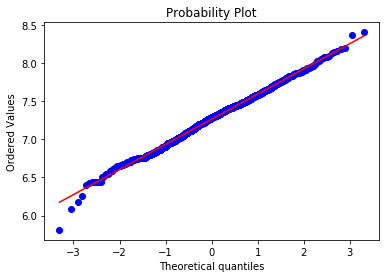

In [159]:
res = stats.probplot(np.log(train['GrLivArea']), plot=plt)

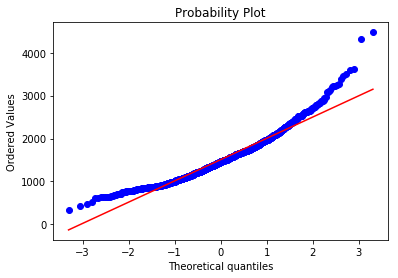

In [160]:
res = stats.probplot(train['GrLivArea'], plot=plt)

In [161]:
sf_cols = ['LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
          'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea']

In [162]:
for df in [train, test]:
    df['GrLivArea_log'] = np.log(df['GrLivArea'])
    df['TotalBsmt_log'] = np.zeros(df.shape[0])
    df['TotalBsmt_log'].loc[df[df['TotalBsmtSF']>0].index] = np.log(df['TotalBsmtSF'])
    df['YrRem-Bui'] = df['YearRemodAdd'] - df['YearBuilt']
    df['1st+2ndSF'] = df['1stFlrSF'] + df['2ndFlrSF']
    for col in sf_cols:
        df[col+'_sqrt'] = np.sqrt(df[col]) 

In [163]:
y_train = train['SalePrice'].values
del train['SalePrice']

In [164]:
total = all_data.isnull().sum().sort_values(ascending = False)
percent = (all_data.isnull().sum()/all_data.isnull().count()).sort_values(ascending = False)
missing_data = pd.concat([total, percent], axis = 1, keys = ['Total', 'Percent'])
missing_data.head(40)

Total   Percent
PoolQC         2909  0.996574
MiscFeature    2814  0.964029
Alley          2721  0.932169
Fence          2348  0.804385
FireplaceQu    1420  0.486468
GarageCond      159  0.054471
GarageFinish    159  0.054471
GarageQual      159  0.054471
GarageType      157  0.053786
BsmtExposure     82  0.028092
BsmtCond         82  0.028092
BsmtQual         81  0.027749
BsmtFinType2     80  0.027407
BsmtFinType1     79  0.027064
MasVnrType       24  0.008222
MSZoning          4  0.001370
Utilities         2  0.000685
Functional        2  0.000685
Exterior2nd       1  0.000343
SaleType          1  0.000343
KitchenQual       1  0.000343
Exterior1st       1  0.000343
Electrical        1  0.000343
LandContour       0  0.000000
RoofMatl          0  0.000000
MasVnrArea        0  0.000000
YearRemodAdd      0  0.000000
ExterQual         0  0.000000
ExterCond         0  0.000000
Foundation        0  0.000000
MSSubClass        0  0.000000
RoofStyle         0  0.000000
OverallCond       0  0.000000
YearBuilt         0  0.000000
OverallQual       0  0.000000
HouseStyle        0  0.000000
BldgType          0  0.000000
LotFrontage       0  0.000000
Condition2        0  0.000000
LotArea           0  0.000000

In [165]:
all_data = pd.concat([train, test], axis=0)
ob_col = all_data.columns[all_data.dtypes==object]

In [166]:
all_data.fillna('NA', inplace=True)

In [167]:
all_data = pd.get_dummies(all_data)

In [168]:
train = all_data.iloc[:train.shape[0], :]
test = all_data.iloc[train.shape[0]:, :]

In [169]:
y_train_log = np.log(y_train)

In [170]:
n_folds = 5
kf = KFold(n_splits=n_folds, shuffle=False, random_state=123)

In [171]:
ss = StandardScaler()
ss.fit(train)
train_ss = ss.transform(train)
test_ss = ss.transform(test)

In [172]:
from sklearn.linear_model import LinearRegression, Lasso

In [173]:
reg_lasso = []
val_rmse_lasso = []

for train_idx, val_idx in kf.split(train):
    X_tr, y_tr = train_ss[train_idx, :], y_train_log[train_idx]
    X_val, y_val = train_ss[val_idx, :], y_train_log[val_idx]
    
    model_lasso = Lasso(alpha=0.005).fit(X_tr, y_tr)
    pred_lasso = model_lasso.predict(X_val)
    val_rmse_lasso.append(np.sqrt(mean_squared_error(y_val, pred_lasso)))
    reg_lasso.append(model_lasso)

print(np.sum(val_rmse_lasso)/n_folds)

0.11090120122910607


In [174]:
coef = pd.Series(model_lasso.coef_, index = train.columns)

In [175]:
coef

MSSubClass              -0.000000e+00
LotFrontage              5.683814e-03
LotArea                  0.000000e+00
OverallQual              2.083389e-02
OverallCond              0.000000e+00
YearBuilt                4.652652e-02
YearRemodAdd             2.247901e-02
MasVnrArea               1.114535e-03
BsmtFinSF1               1.849969e-02
BsmtFinSF2               0.000000e+00
BsmtUnfSF               -0.000000e+00
TotalBsmtSF              3.521171e-02
1stFlrSF                 0.000000e+00
2ndFlrSF                 0.000000e+00
LowQualFinSF             0.000000e+00
GrLivArea                2.812528e-02
BsmtFullBath             1.011780e-02
BsmtHalfBath            -0.000000e+00
FullBath                 5.429112e-03
HalfBath                 0.000000e+00
BedroomAbvGr            -0.000000e+00
KitchenAbvGr            -1.334281e-02
TotRmsAbvGrd             0.000000e+00
Fireplaces               7.642881e-03
GarageYrBlt              0.000000e+00
GarageCars               1.688506e-02
GarageArea  

In [176]:
dropf = coef.loc[coef==0].index
print(dropf)

Index(['MSSubClass', 'LotArea', 'OverallCond', 'BsmtFinSF2', 'BsmtUnfSF',
       '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'BsmtHalfBath', 'HalfBath',
       ...
       'SaleType_COD', 'SaleType_ConLI', 'SaleType_ConLw', 'SaleType_NA',
       'SaleType_Oth', 'SaleType_WD', 'SaleCondition_AdjLand',
       'SaleCondition_Alloca', 'SaleCondition_Normal',
       'SaleCondition_Partial'],
      dtype='object', length=237)


In [177]:
train = train.drop(dropf, axis=1)

In [178]:
lgb_params = {
               'feature_fraction': 0.75,
               'max_depth': 2,
               'metric': 'rmse',
               'nthread':8, 
               'learning_rate': 0.1, 
               'objective': 'mse', 
               'num_leaves': 2**4,
               'verbose':0 
              }

In [179]:
reg = []
val_rmse = []

for train_idx, val_idx in kf.split(train):
    X_tr, y_tr = train.iloc[train_idx, :], y_train_log[train_idx]
    X_val, y_val = train.iloc[val_idx, :], y_train_log[val_idx]
 
    model_lgb = lgb.train(lgb_params, lgb.Dataset(X_tr, label=y_tr), 500,\
                           valid_sets=lgb.Dataset(X_val, label=y_val), early_stopping_rounds=100)
    pred_lgb = model_lgb.predict(X_val)
    val_rmse.append(np.sqrt(mean_squared_error(y_val, pred_lgb)))
    reg.append(model_lgb)

[1]	valid_0's rmse: 0.363222
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's rmse: 0.343298
[3]	valid_0's rmse: 0.324908
[4]	valid_0's rmse: 0.306641
[5]	valid_0's rmse: 0.291226
[6]	valid_0's rmse: 0.279433
[7]	valid_0's rmse: 0.265376
[8]	valid_0's rmse: 0.25407
[9]	valid_0's rmse: 0.243281
[10]	valid_0's rmse: 0.23377
[11]	valid_0's rmse: 0.226244
[12]	valid_0's rmse: 0.217799
[13]	valid_0's rmse: 0.210642
[14]	valid_0's rmse: 0.204104
[15]	valid_0's rmse: 0.197962
[16]	valid_0's rmse: 0.192488
[17]	valid_0's rmse: 0.187489
[18]	valid_0's rmse: 0.183847
[19]	valid_0's rmse: 0.179376
[20]	valid_0's rmse: 0.175923
[21]	valid_0's rmse: 0.172655
[22]	valid_0's rmse: 0.169082
[23]	valid_0's rmse: 0.165302
[24]	valid_0's rmse: 0.16253
[25]	valid_0's rmse: 0.159874
[26]	valid_0's rmse: 0.156982
[27]	valid_0's rmse: 0.15482
[28]	valid_0's rmse: 0.153651
[29]	valid_0's rmse: 0.152155
[30]	valid_0's rmse: 0.149989
[31]	valid_0's rmse: 0.148326
[32]	valid_0's rmse:

[316]	valid_0's rmse: 0.115691
[317]	valid_0's rmse: 0.115693
[318]	valid_0's rmse: 0.115724
[319]	valid_0's rmse: 0.115719
[320]	valid_0's rmse: 0.115757
[321]	valid_0's rmse: 0.115743
[322]	valid_0's rmse: 0.115746
[323]	valid_0's rmse: 0.115833
[324]	valid_0's rmse: 0.115782
[325]	valid_0's rmse: 0.115795
[326]	valid_0's rmse: 0.115809
[327]	valid_0's rmse: 0.115881
[328]	valid_0's rmse: 0.115922
[329]	valid_0's rmse: 0.115904
[330]	valid_0's rmse: 0.115811
[331]	valid_0's rmse: 0.115805
[332]	valid_0's rmse: 0.115799
[333]	valid_0's rmse: 0.115762
[334]	valid_0's rmse: 0.115799
[335]	valid_0's rmse: 0.115778
[336]	valid_0's rmse: 0.115728
[337]	valid_0's rmse: 0.115646
[338]	valid_0's rmse: 0.11564
[339]	valid_0's rmse: 0.115719
[340]	valid_0's rmse: 0.115655
[341]	valid_0's rmse: 0.115549
[342]	valid_0's rmse: 0.11551
[343]	valid_0's rmse: 0.115502
[344]	valid_0's rmse: 0.115506
[345]	valid_0's rmse: 0.115496
[346]	valid_0's rmse: 0.115381
[347]	valid_0's rmse: 0.115367
[348]	vali

[93]	valid_0's rmse: 0.133348
[94]	valid_0's rmse: 0.133343
[95]	valid_0's rmse: 0.133411
[96]	valid_0's rmse: 0.133412
[97]	valid_0's rmse: 0.133153
[98]	valid_0's rmse: 0.13295
[99]	valid_0's rmse: 0.132835
[100]	valid_0's rmse: 0.132825
[101]	valid_0's rmse: 0.132825
[102]	valid_0's rmse: 0.132774
[103]	valid_0's rmse: 0.132721
[104]	valid_0's rmse: 0.132822
[105]	valid_0's rmse: 0.132748
[106]	valid_0's rmse: 0.132789
[107]	valid_0's rmse: 0.13265
[108]	valid_0's rmse: 0.132461
[109]	valid_0's rmse: 0.132392
[110]	valid_0's rmse: 0.132224
[111]	valid_0's rmse: 0.132278
[112]	valid_0's rmse: 0.132265
[113]	valid_0's rmse: 0.132253
[114]	valid_0's rmse: 0.132256
[115]	valid_0's rmse: 0.132279
[116]	valid_0's rmse: 0.132253
[117]	valid_0's rmse: 0.132139
[118]	valid_0's rmse: 0.132159
[119]	valid_0's rmse: 0.132028
[120]	valid_0's rmse: 0.131893
[121]	valid_0's rmse: 0.131859
[122]	valid_0's rmse: 0.131807
[123]	valid_0's rmse: 0.131824
[124]	valid_0's rmse: 0.131876
[125]	valid_0's r

[391]	valid_0's rmse: 0.126563
[392]	valid_0's rmse: 0.126549
[393]	valid_0's rmse: 0.126585
[394]	valid_0's rmse: 0.126558
[395]	valid_0's rmse: 0.126521
[396]	valid_0's rmse: 0.126501
[397]	valid_0's rmse: 0.126471
[398]	valid_0's rmse: 0.126446
[399]	valid_0's rmse: 0.12643
[400]	valid_0's rmse: 0.126402
[401]	valid_0's rmse: 0.126403
[402]	valid_0's rmse: 0.126349
[403]	valid_0's rmse: 0.126377
[404]	valid_0's rmse: 0.126415
[405]	valid_0's rmse: 0.126429
[406]	valid_0's rmse: 0.126452
[407]	valid_0's rmse: 0.126401
[408]	valid_0's rmse: 0.126374
[409]	valid_0's rmse: 0.126447
[410]	valid_0's rmse: 0.126484
[411]	valid_0's rmse: 0.126474
[412]	valid_0's rmse: 0.126561
[413]	valid_0's rmse: 0.126514
[414]	valid_0's rmse: 0.126594
[415]	valid_0's rmse: 0.126608
[416]	valid_0's rmse: 0.126611
[417]	valid_0's rmse: 0.126606
[418]	valid_0's rmse: 0.12658
[419]	valid_0's rmse: 0.126589
[420]	valid_0's rmse: 0.126549
[421]	valid_0's rmse: 0.126616
[422]	valid_0's rmse: 0.126612
[423]	vali

[337]	valid_0's rmse: 0.122423
[338]	valid_0's rmse: 0.122474
[339]	valid_0's rmse: 0.122459
[340]	valid_0's rmse: 0.122424
[341]	valid_0's rmse: 0.122496
[342]	valid_0's rmse: 0.122495
[343]	valid_0's rmse: 0.122476
[344]	valid_0's rmse: 0.122447
[345]	valid_0's rmse: 0.122387
[346]	valid_0's rmse: 0.122373
[347]	valid_0's rmse: 0.122333
[348]	valid_0's rmse: 0.122348
[349]	valid_0's rmse: 0.122292
[350]	valid_0's rmse: 0.122315
[351]	valid_0's rmse: 0.122367
[352]	valid_0's rmse: 0.122381
[353]	valid_0's rmse: 0.122402
[354]	valid_0's rmse: 0.122461
[355]	valid_0's rmse: 0.122449
[356]	valid_0's rmse: 0.122451
[357]	valid_0's rmse: 0.122437
[358]	valid_0's rmse: 0.122437
[359]	valid_0's rmse: 0.122414
[360]	valid_0's rmse: 0.122455
[361]	valid_0's rmse: 0.122456
[362]	valid_0's rmse: 0.122403
[363]	valid_0's rmse: 0.122317
[364]	valid_0's rmse: 0.122287
[365]	valid_0's rmse: 0.122179
[366]	valid_0's rmse: 0.12217
[367]	valid_0's rmse: 0.122117
[368]	valid_0's rmse: 0.122163
[369]	val

[249]	valid_0's rmse: 0.112676
[250]	valid_0's rmse: 0.112605
[251]	valid_0's rmse: 0.112542
[252]	valid_0's rmse: 0.11244
[253]	valid_0's rmse: 0.112437
[254]	valid_0's rmse: 0.112411
[255]	valid_0's rmse: 0.112419
[256]	valid_0's rmse: 0.112368
[257]	valid_0's rmse: 0.11236
[258]	valid_0's rmse: 0.112258
[259]	valid_0's rmse: 0.112282
[260]	valid_0's rmse: 0.112344
[261]	valid_0's rmse: 0.112365
[262]	valid_0's rmse: 0.112354
[263]	valid_0's rmse: 0.112311
[264]	valid_0's rmse: 0.112229
[265]	valid_0's rmse: 0.112278
[266]	valid_0's rmse: 0.112309
[267]	valid_0's rmse: 0.112242
[268]	valid_0's rmse: 0.112155
[269]	valid_0's rmse: 0.112076
[270]	valid_0's rmse: 0.11206
[271]	valid_0's rmse: 0.111983
[272]	valid_0's rmse: 0.111939
[273]	valid_0's rmse: 0.11189
[274]	valid_0's rmse: 0.111844
[275]	valid_0's rmse: 0.111902
[276]	valid_0's rmse: 0.111893
[277]	valid_0's rmse: 0.111966
[278]	valid_0's rmse: 0.111943
[279]	valid_0's rmse: 0.111903
[280]	valid_0's rmse: 0.111846
[281]	valid_

[334]	valid_0's rmse: 0.116681
[335]	valid_0's rmse: 0.116569
[336]	valid_0's rmse: 0.116578
[337]	valid_0's rmse: 0.116562
[338]	valid_0's rmse: 0.116561
[339]	valid_0's rmse: 0.116557
[340]	valid_0's rmse: 0.116545
[341]	valid_0's rmse: 0.116512
[342]	valid_0's rmse: 0.116425
[343]	valid_0's rmse: 0.116425
[344]	valid_0's rmse: 0.116433
[345]	valid_0's rmse: 0.116459
[346]	valid_0's rmse: 0.116435
[347]	valid_0's rmse: 0.116453
[348]	valid_0's rmse: 0.116509
[349]	valid_0's rmse: 0.116491
[350]	valid_0's rmse: 0.116433
[351]	valid_0's rmse: 0.116564
[352]	valid_0's rmse: 0.116564
[353]	valid_0's rmse: 0.116637
[354]	valid_0's rmse: 0.116538
[355]	valid_0's rmse: 0.116575
[356]	valid_0's rmse: 0.1165
[357]	valid_0's rmse: 0.116597
[358]	valid_0's rmse: 0.116553
[359]	valid_0's rmse: 0.11646
[360]	valid_0's rmse: 0.116484
[361]	valid_0's rmse: 0.116529
[362]	valid_0's rmse: 0.116491
[363]	valid_0's rmse: 0.11648
[364]	valid_0's rmse: 0.1164
[365]	valid_0's rmse: 0.116437
[366]	valid_0'

In [180]:
np.sum(val_rmse)/n_folds

0.11722347903304058

In [181]:
feature_imp = np.zeros(train.shape[1])
for model in reg:
    feature_imp+=model.feature_importance()

In [182]:
pd.DataFrame({'Importance':feature_imp/n_folds}, index=train.columns).sort_values(by='Importance', ascending=False)

Importance
OverallQual                 110.8
LotArea_sqrt                 79.6
YearBuilt                    74.0
GrLivArea                    63.4
1st+2ndSF                    60.2
GarageArea                   59.0
TotalBsmtSF                  58.4
1stFlrSF_sqrt                57.4
BsmtFinSF1                   52.2
OverallQual*Cond             46.4
LotFrontage                  43.2
YearRemodAdd                 38.2
OpenPorchSF_sqrt             36.2
WoodDeckSF                   24.8
YrSold                       21.8
KitchenAbvGr                 20.8
Functional_Typ               20.0
MasVnrArea                   19.0
OverallQual+Cond             18.2
Neighborhood_BrkSide         16.8
Neighborhood_Crawfor         16.4
Exterior1st_BrkFace          16.2
SaleCondition_Abnorml        15.8
BsmtFullBath                 15.6
TotalBsmtSF_sqrt             15.0
ScreenPorch                  15.0
FullBath                     14.6
GarageArea_sqrt              13.8
Condition1_Norm              13.4
Fence_GdWo                   12.6
Neighborhood_Somerst         11.4
BsmtFinSF1_sqrt              11.2
LotConfig_CulDSac            11.2
Neighborhood_StoneBr         11.2
GrLivArea_log                10.8
BsmtExposure_Gd              10.2
Fireplaces                    9.4
CentralAir_N                  8.2
HeatingQC_TA                  8.0
Condition1_Artery             7.8
Neighborhood_Edwards          7.4
WoodDeckSF_sqrt               7.0
BsmtExposure_No               6.8
Neighborhood_Mitchel          6.2
SaleType_New                  6.0
KitchenQual_Ex                5.6
PavedDrive_Y                  5.4
Exterior1st_Wd Sdng           5.4
ExterCond_TA                  5.2
GarageQual_Fa                 5.2
MSZoning_RM                   5.0
Neighborhood_NridgHt          5.0
Neighborhood_ClearCr          4.8
HeatingQC_Ex                  4.6
GarageCars                    4.4
Foundation_PConc              4.2
ExterCond_Fa                  3.8
GarageFinish_Unf              3.4
BsmtQual_TA                   3.4
Exterior1st_HdBoard           3.2
LotConfig_FR2                 2.4
GarageType_BuiltIn            2.4
ExterQual_TA                  2.4
GarageCond_TA                 2.2
Neighborhood_NWAmes           2.2
FireplaceQu_Gd                2.2
LandSlope_Mod                 2.0
BsmtQual_Ex                   1.8
CentralAir_Y                  1.4
LotShape_IR2                  1.4
BldgType_Duplex               1.0
FireplaceQu_NA                0.8
MasVnrType_Stone              0.6
BldgType_Twnhs                0.6
Neighborhood_NoRidge          0.2
MiscFeature_Othr              0.0
SaleType_CWD                  0.0
SaleType_Con                  0.0
GarageQual_Ex                 0.0
SaleType_ConLD                0.0
Condition2_PosA               0.0
Functional_Sev                0.0
Functional_Mod                0.0
Functional_Maj2               0.0
Heating_Grav                  0.0
Heating_GasW                  0.0
Foundation_Stone              0.0
MasVnrType_BrkCmn             0.0
Exterior1st_BrkComm           0.0
RoofMatl_WdShngl              0.0
RoofMatl_Membran              0.0
RoofStyle_Gambrel             0.0
Condition1_RRAe               0.0
Neighborhood_MeadowV          0.0
MSZoning_C (all)              0.0
SaleCondition_Family          0.0

In [183]:
test = test.drop(dropf, axis=1)

In [184]:
reg_lasso = []
val_rmse_lasso = []

ss.fit(train)
train_ss = ss.transform(train)
test_ss = ss.transform(test)

for train_idx, val_idx in kf.split(train):
    X_tr, y_tr = train_ss[train_idx, :], y_train_log[train_idx]
    X_val, y_val = train_ss[val_idx, :], y_train_log[val_idx]
    
    model_lasso = Lasso(alpha=0.005).fit(X_tr, y_tr)
    pred_lasso = model_lasso.predict(X_val)
    val_rmse_lasso.append(np.sqrt(mean_squared_error(y_val, pred_lasso)))
    reg_lasso.append(model_lasso)

print(np.sum(val_rmse_lasso)/n_folds)

0.10966586403789595


In [185]:
preds = None

for model in reg_lasso:
    if preds is None:
        preds = model.predict(test_ss) / n_folds
    else:
        preds += model.predict(test_ss) / n_folds

In [186]:
np.exp(preds)

array([121120.32324179, 158461.51269321, 182062.29614195, ...,
       172789.73402645, 119766.21843824, 228203.15092291])

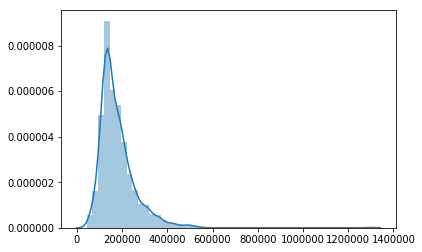

In [187]:
sns.distplot(np.exp(preds))

In [ ]:
solution = pd.DataFrame({"id":test_id, "SalePrice":np.exp(preds)})
solution.to_csv("submission_31.csv", index = False)